In [87]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import unittest
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
from flask import Flask, request, jsonify
import docker

In [83]:
!pip install logging


  Using cached logging-0.4.9.6.tar.gz (96 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [24 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 14, in <module>
    File "C:\Users\ASUS\anaconda3\Lib\site-packages\setuptools\__init__.py", line 22, in <module>
      import _distutils_hack.override  # noqa: F401
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\ASUS\anaconda3\Lib\site-packages\_distutils_hack\override.py", line 1, in <module>
      __import__('_distutils_hack').do_override()
    File "C:\Users\ASUS\anaconda3\Lib\site-packages\_distutils_hack\__init__.py", line 90, in do_override
      ensure_local_distutils()
    File "C:\Users\ASUS\anaconda3\Lib\site-packages\_distutils_hack\__init__.py", line 76, in ensure_local_distutils
      core = importlib.import_module('distutils.core')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\ASUS\an

In [89]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


In [91]:
# Load the dataset
logger.info("Loading dataset...")
df=pd.read_csv(r"C:\Users\ASUS\Downloads\MLE-Assignment.csv")

2025-03-16 22:26:42,052 - INFO - Loading dataset...


In [13]:
#seeing the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB


In [15]:
df.head()


,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [17]:
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

Total missing values: 0


In [19]:
df.describe

<bound method NDFrame.describe of                hsi_id         0         1         2         3         4  \
0      imagoai_corn_0  0.416181  0.396844  0.408985  0.372865  0.385293   
1      imagoai_corn_1  0.415797  0.402956  0.402564  0.396014  0.397192   
2      imagoai_corn_2  0.389023  0.371206  0.373098  0.373872  0.361056   
3      imagoai_corn_3  0.468837  0.473255  0.462949  0.459335  0.461672   
4      imagoai_corn_4  0.483352  0.487274  0.469153  0.487648  0.464026   
..                ...       ...       ...       ...       ...       ...   
495  imagoai_corn_495  0.478140  0.444033  0.442120  0.437473  0.428672   
496  imagoai_corn_496  0.409367  0.394941  0.380236  0.375340  0.346122   
497  imagoai_corn_497  0.486526  0.501372  0.500175  0.508139  0.489411   
498  imagoai_corn_498  0.464595  0.498822  0.489077  0.453381  0.487636   
499  imagoai_corn_499  0.460840  0.457656  0.434632  0.412675  0.418638   

            5         6         7         8  ...       439       

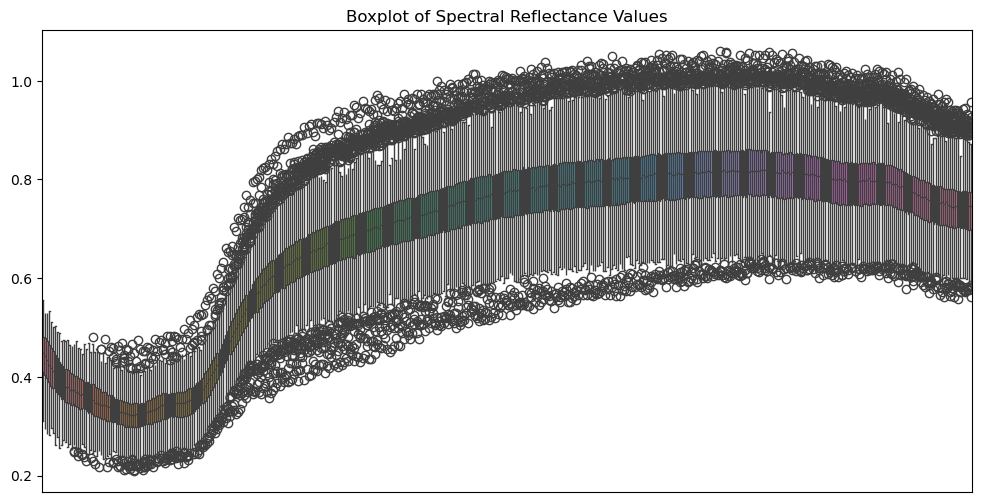

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.iloc[:, 1:-1])  # Exclude ID and target variable
plt.xticks([])
plt.title("Boxplot of Spectral Reflectance Values")
plt.show()

In [25]:
# Handle missing values
df.iloc[:, 1:-1] = df.iloc[:, 1:-1].apply(lambda x: x.fillna(x.median()), axis=0)

In [27]:

# Normalize spectral data (excluding ID and target variable)
scaler = StandardScaler()
df.iloc[:, 1:-1] = scaler.fit_transform(df.iloc[:, 1:-1])

In [29]:
# Check for anomalies (Z-score method)
z_scores = np.abs((df.iloc[:, 1:-1] - df.iloc[:, 1:-1].mean()) / df.iloc[:, 1:-1].std())
anomalies = (z_scores > 3).sum().sum()
print(f"Total anomalies detected: {anomalies}")


Total anomalies detected: 2343


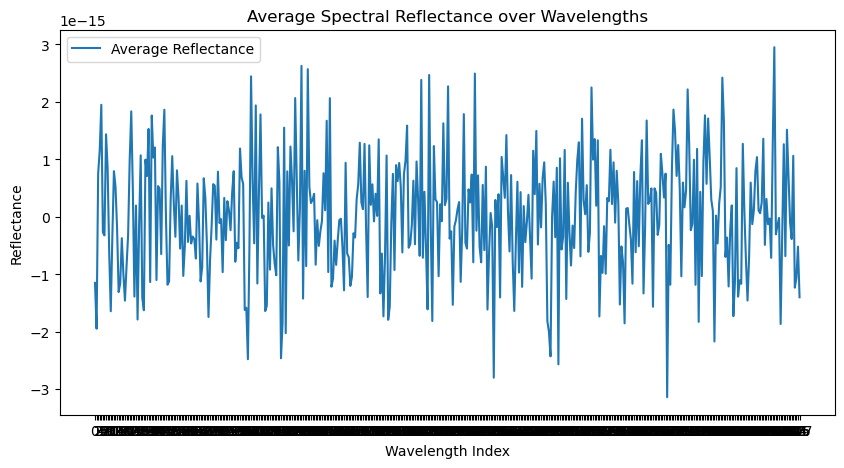

In [31]:
# Line plot for average reflectance
plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:, 1:-1].mean(), label='Average Reflectance')
plt.xlabel("Wavelength Index")
plt.ylabel("Reflectance")
plt.title("Average Spectral Reflectance over Wavelengths")
plt.legend()
plt.show()


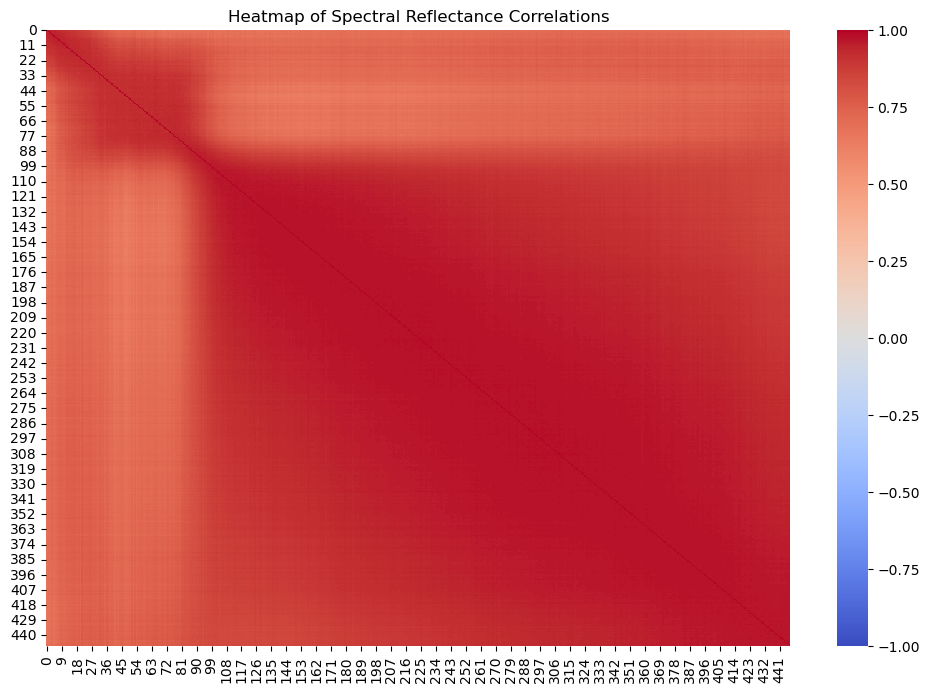

In [33]:
# Heatmap for correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[:, 1:-1].corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap of Spectral Reflectance Correlations")
plt.show()

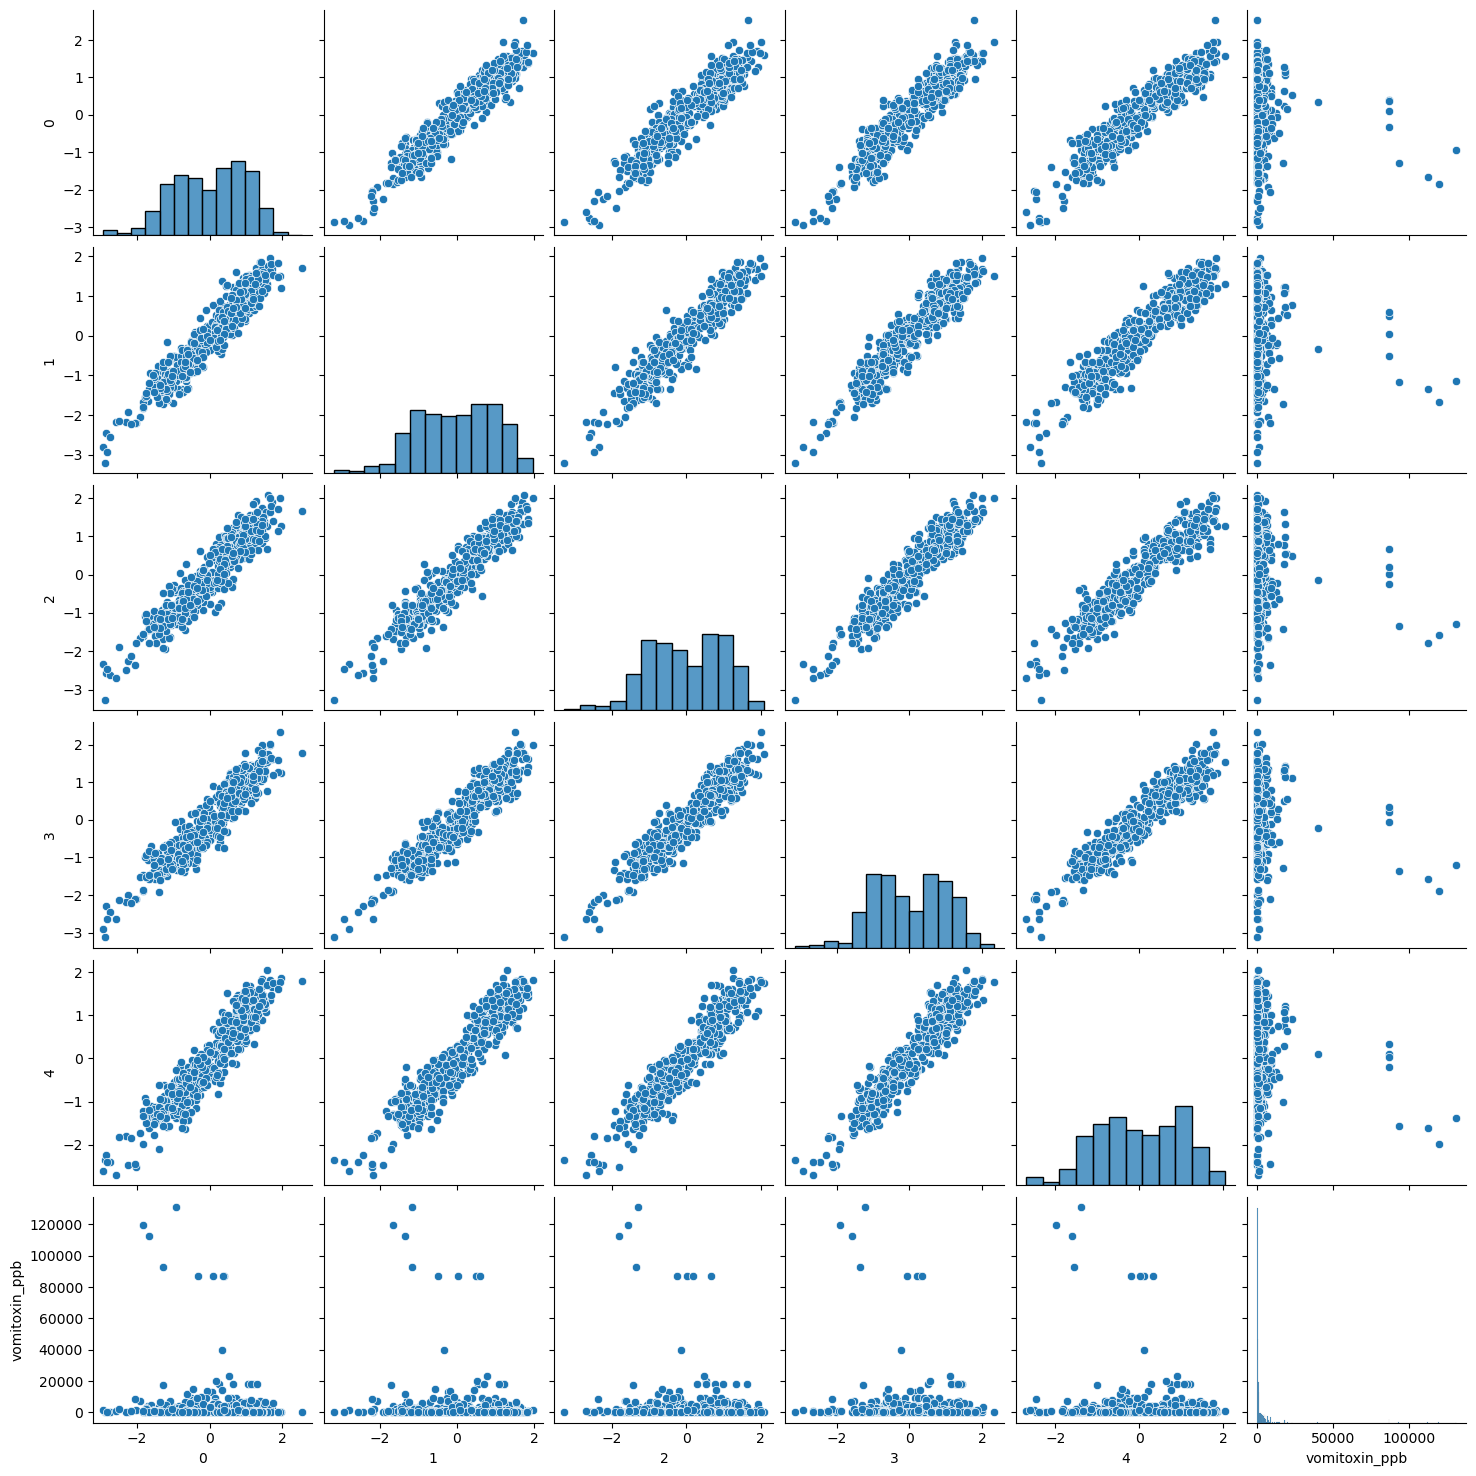

In [37]:

# Pairplot of first 5 wavelengths with target variable
sns.pairplot(df.iloc[:, np.r_[1:6, -1]])
plt.show()


In [39]:
# Split data into features and target
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [47]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Baseline Model: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [51]:

# Simple Neural Network (MLP)
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_test)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
# Model Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae}, RMSE: {rmse}, R² Score: {r2}")
    return mae, rmse, r2

evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, mlp_preds, "MLP Neural Network")


Random Forest - MAE: 3765.0568, RMSE: 11483.805982806223, R² Score: 0.5282211884116356
MLP Neural Network - MAE: 3342.7449896232097, RMSE: 9834.362432085041, R² Score: 0.6540134962629431


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(3342.7449896232097, 9834.362432085041, 0.6540134962629431)

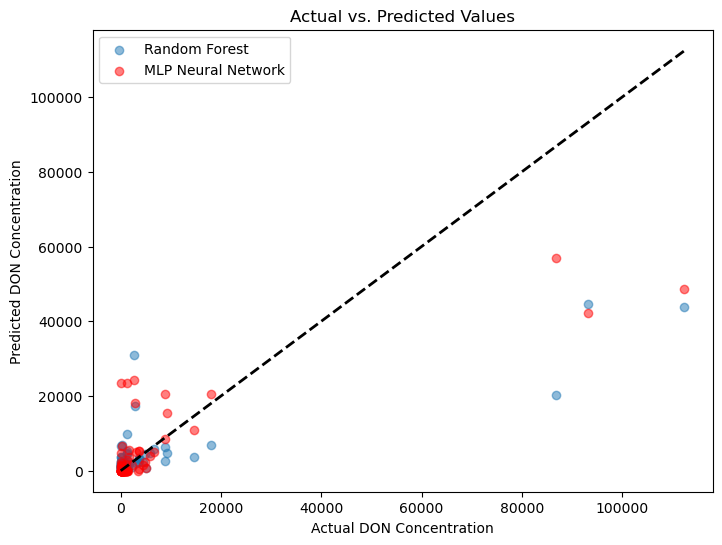

In [55]:
# Scatter plot: Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_preds, alpha=0.5, label="Random Forest")
plt.scatter(y_test, mlp_preds, alpha=0.5, label="MLP Neural Network", color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.show()

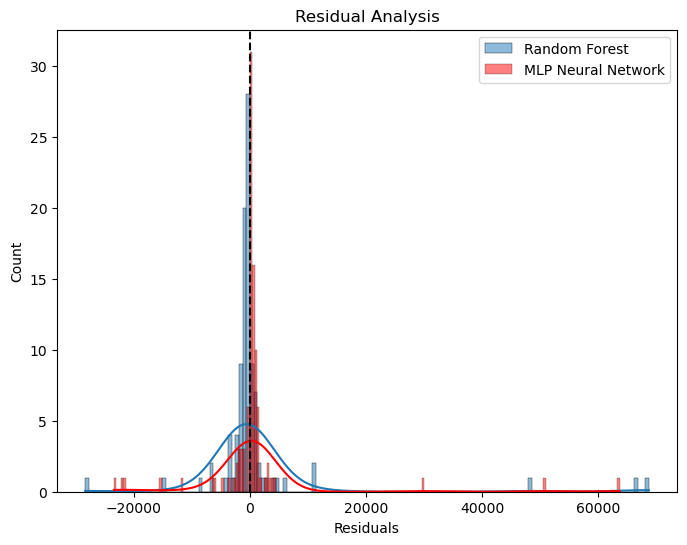

In [57]:
# Residual Analysis
rf_residuals = y_test - rf_preds
mlp_residuals = y_test - mlp_preds

plt.figure(figsize=(8, 6))
sns.histplot(rf_residuals, kde=True, label="Random Forest")
sns.histplot(mlp_residuals, kde=True, label="MLP Neural Network", color='red')
plt.axvline(0, color='black', linestyle='dashed')
plt.xlabel("Residuals")
plt.title("Residual Analysis")
plt.legend()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24904\3665541936.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_indices][:20], y=feature_names[sorted_indices][:20], palette="viridis")


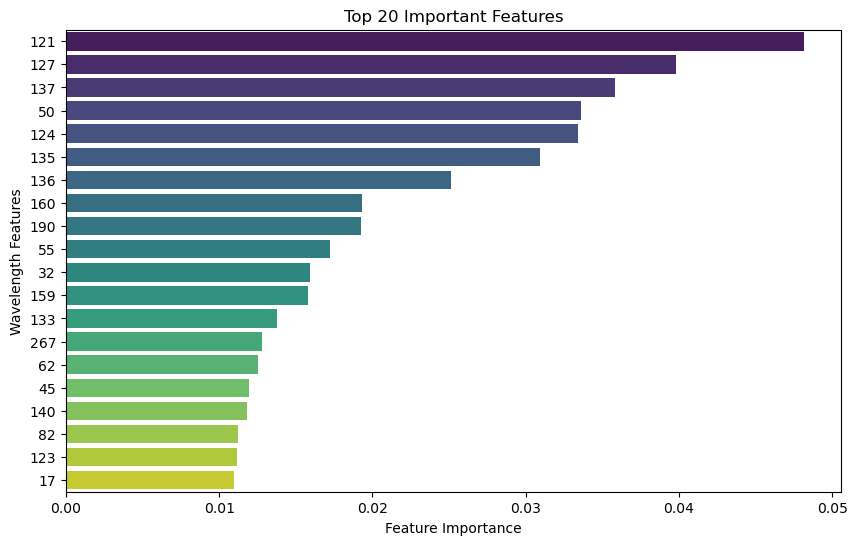

In [63]:
# Feature Importance using Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices][:20], y=feature_names[sorted_indices][:20], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Wavelength Features")
plt.title("Top 20 Important Features")
plt.show()


In [93]:
# Save the trained model
import joblib
joblib.dump(rf_model, "rf_model.pkl")
logging.info("Model saved as rf_model.pkl")

2025-03-16 22:27:58,693 - INFO - Model saved as rf_model.pkl


In [95]:
# Flask API for Model Deployment
app = Flask(__name__)


In [97]:
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    input_data = np.array(data['features']).reshape(1, -1)
    prediction = rf_model.predict(input_data)
    return jsonify({"prediction": prediction.tolist()})

In [99]:
if __name__ == '__main__':
    app.run(debug=True)

# Unit Testing
class TestModel(unittest.TestCase):
    def test_prediction(self):
        sample_input = X_test.iloc[0].values.reshape(1, -1)
        prediction = rf_model.predict(sample_input)
        self.assertTrue(isinstance(prediction[0], float))

if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

 * Serving Flask app '__main__'
 * Debug mode: on


2025-03-16 22:28:42,812 - INFO - WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
2025-03-16 22:28:42,814 - INFO - Press CTRL+C to quit
2025-03-16 22:28:42,860 - INFO -  * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [101]:
# Docker Integration (Packaging the Model)
logger.info("Setting up Docker container...")
with open("Dockerfile", "w") as dockerfile:
    dockerfile.write(
        """
        FROM python:3.8
        WORKDIR /app
        COPY . /app
        RUN pip install -r requirements.txt
        CMD ["python", "app.py"]
        """
    )
logger.info("Dockerfile created.")

2025-03-16 22:29:02,457 - INFO - Setting up Docker container...
2025-03-16 22:29:02,462 - INFO - Dockerfile created.


In [103]:
# Creating requirements.txt
with open("requirements.txt", "w") as req:
    req.write("""
    pandas
    numpy
    seaborn
    matplotlib
    sklearn
    flask
    joblib
    docker
    """)
logger.info("requirements.txt created.")

2025-03-16 22:29:17,829 - INFO - requirements.txt created.


In [107]:
# Build and Run Docker Container
try:
    client = docker.from_env()
    image, _ = client.images.build(path=".", tag="ml_model")
    container = client.containers.run("ml_model", detach=True)
    logger.info("Docker container is running.")
except docker.errors.DockerException as e:
    logger.error(f"Error while setting up Docker: {e}")

2025-03-16 22:32:20,071 - ERROR - Error while setting up Docker: Error while fetching server API version: (2, 'CreateFile', 'The system cannot find the file specified.')
